# Benchmark workshop live session

## Learning objectives
<br>

By the end of this workshop you will be able to:
 1. Identify torsion violations 
 2. Identify forcefield parameters associated with torsion violations
 3. Visualize violation frequency as a function of torsion parameter

In [1]:
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import PandasTools
from tqdm import tqdm
from glob import glob

import pandas as pd
import numpy as np
import os
import json

## 1. Identify torsion violations

This first part of the code section loads the sdf files of the QM and MM methods, then goes through all the torsions
to compare the QM and MM values and outputs the conformers that exhibit a torsion deviation larger than a given threshold.
Since a given torsion is defined by 4 atoms indices, but the bond which is rotating is always defined by the 2 middle indices, a single rotatable bond may be identified as an outlier multiple times since it is central to multiple torsions. 
The last part of this code section removes such duplicates.

In [2]:
qm_glob = 'data/b3lyp-d3bj/dzvp/*.sdf'
mm_glob = 'data/openff-1.3.0/*.sdf'

qm_data = []
for sdf in glob(qm_glob):
    df = PandasTools.LoadSDF(sdf)
    qm_data.append(df)

qm_data = pd.concat(qm_data)
qm_data = qm_data[['conformer_index', 'molecule_index', 'final_energy', 'ID', 'ROMol']]
qm_data.columns = ['confID', 'MolID', 'Eqm', 'ID', 'mol_qm']

mm_data = []
for sdf in glob(mm_glob):
    df = PandasTools.LoadSDF(sdf)
    mm_data.append(df)
    
mm_data = pd.concat(mm_data)
mm_data = mm_data[['ID', 'ROMol']]
mm_data.columns = ['ID', 'mol_off']

df = pd.merge(qm_data, mm_data, on='ID')

df['Eqm_kcal_per_mol'] = df['Eqm'].str.replace('kilocalorie / mole', '')
df = df.astype({'Eqm_kcal_per_mol': float})

df.sort_values(by=['MolID', 'Eqm_kcal_per_mol'], inplace=True)

df = df.groupby(['MolID']).first()

In [3]:
def chk_valence(df, t_thresh=10.):
    """
    compare torsions values from qm and mm geometries

    go through all torsions in the molecule, calculate the values for both qm and mm
    conformation and output if larger than the corresponding threshold

    Args:
        df (pd.DataFrame): dataframe holding conformations and identifier
        t_thresh (float): threshold for torsion deviation in degrees
               
    Returns:
        pd.DataFrame holding the valence violations

    """

    t_violations = []
    
    for i, row in df.iterrows():
        mol1, mol2 = row[['mol_qm','mol_off']]

        name = mol1.GetProp("_Name")
        
        # collect all bonds as pairs of atom indices
        bonds = [(x.GetBeginAtomIdx(), x.GetEndAtomIdx()) for x in mol1.GetBonds()]
        conf1 = mol1.GetConformer()
        conf2 = mol2.GetConformer()

        nAtoms = mol1.GetNumAtoms()
        for i in range(nAtoms):
            ie = mol1.GetAtomWithIdx(i).GetSymbol()

            # if atom has 3 neighbors, calculate improper torsion value
            neighbors = mol1.GetAtomWithIdx(i).GetNeighbors()
            if len(neighbors) == 3:
                nn =[]
                for n in neighbors:
                    nn.append(n.GetIdx())

                je = mol1.GetAtomWithIdx(nn[0]).GetSymbol()
                ke = mol1.GetAtomWithIdx(nn[1]).GetSymbol()
                le = mol1.GetAtomWithIdx(nn[2]).GetSymbol()


            # get the second atom for the bond calculation
            for j in range(i, nAtoms):

                # if atom 2 is not bonded to atom 1, skip
                if (i,j) not in bonds and (j,i) not in bonds:
                    continue

                je = mol1.GetAtomWithIdx(j).GetSymbol()


                # get the third atom for angle calculation
                for k in range(nAtoms):

                    # if atom 3 is not bonded to atom 2, skip
                    if (j, k) not in bonds and (k, j) not in bonds:
                        continue

                    ke = mol1.GetAtomWithIdx(k).GetSymbol()

                    # check that we have 3 distinct atoms
                    test = ([i, j, k])
                    if len(test) != 3:
                        continue


                    # get the fourth atom
                    for l in range(nAtoms):

                        # check that atom 4 is bonded to atom 3
                        if (k, l) not in bonds and (l, k) not in bonds:
                            continue

                        le = mol1.GetAtomWithIdx(l).GetSymbol()

                        # check if 4 distinct atoms
                        test = ([i,j,k,l])
                        if len(test) != 4:
                            continue


                        t1 = round(rdMolTransforms.GetDihedralDeg(conf1, i, j, k, l), 2)
                        t2 = round(rdMolTransforms.GetDihedralDeg(conf2, i, j, k, l), 2)
                        diff = round(abs(t1-t2), 2)
                        if diff > 180:
                            diff = abs(diff - 360)

                        if diff > t_thresh :
                            
                            t_violations.append([name, ie, je, ke, le, i+1, j+1, k+1, l+1, t1, t2, diff])

    
    # convert violation lists into a common dataframe

    t_violations = pd.DataFrame(t_violations)
    if len(t_violations.index) != 0:
        t_violations.columns = ['ID', 'at1', 'at2', 'at3', 'at4', 'i', 'j', 'k', 'l', 'val_qm', 'val_off', 'difference']

    dfout = pd.DataFrame(t_violations)
    
    dfout = dfout[['ID', 'at1', 'at2', 'at3', 'at4', 'i', 'j', 'k', 'l', 'val_qm', 'val_off', 'difference']]
           
    
    return dfout

In [4]:
t_thresh = 30.0
dfout = chk_valence(df, t_thresh)
print(dfout.to_string())

#dfout.to_csv('violations.csv')

               ID at1 at2 at3 at4   i   j   k   l  val_qm  val_off  difference
0    JNS-00129-06   N   C   C   F  14  15  18  19  179.82  -121.67       58.51
1    JNS-00129-06   N   C   C   F  14  15  18  20   59.86   119.98       60.12
2    JNS-00129-06   N   C   C   F  14  15  18  21  -60.21    -0.93       59.28
3    XTP-00455-03   C   C   C   F   2  12  14  15 -118.17   -59.29       58.88
4    XTP-00455-03   C   C   C   F   2  12  14  16  121.60   179.91       58.31
5    XTP-00455-03   C   C   C   F   2  12  14  17    1.61    59.16       57.55
6    GNT-00519-00   F   C   C   C   3  20  14  10  118.09    56.79       61.30
7    GNT-00519-00   F   C   C   N   3  20  14  11  -60.71  -121.56       60.85
8    GNT-00519-00   F   C   C   C   4  20  14  10 -121.78   177.54       60.68
9    GNT-00519-00   F   C   C   N   4  20  14  11   59.42    -0.81       60.23
10   GNT-00519-00   F   C   C   C   5  20  14  10   -1.83   -61.65       59.82
11   GNT-00519-00   F   C   C   N   5  20  14  11  1

### (Beginning of proposed replacement for the two blocks above)
### From Jeff: Simpler replacement for above? (reports more violations since it allows i<j)

In [5]:
t_violations = list()
threshold_degrees = 30.
for i, row in df.iterrows():
    mol1, mol2 = row[['mol_qm','mol_off']]

    name = mol1.GetProp("_Name")
    
    conf1 = mol1.GetConformer()
    conf2 = mol2.GetConformer()
    
    # Search for all dihedrals i-j-k-l by iterating over all possible j-k bonds
    for bond in mol1.GetBonds():
        atom_j = bond.GetBeginAtom()
        atom_k = bond.GetEndAtom()
        
        # Iterate over bonded neighbors of j that are not k
        for atom_i in atom_j.GetNeighbors():
            if atom_i == atom_k:
                continue
            # Iterate over bonded neighbors of k that are not j
            for atom_l in atom_k.GetNeighbors():
                if (atom_l == atom_j):
                    continue
                
                # Compare the measured angle of the dihedral in the QM and MM structures
                t1 = round(rdMolTransforms.GetDihedralDeg(conf1, 
                                                          atom_i.GetIdx(), 
                                                          atom_j.GetIdx(),
                                                          atom_k.GetIdx(),
                                                          atom_l.GetIdx(),
                                                          ), 2)
                t2 = round(rdMolTransforms.GetDihedralDeg(conf2, 
                                                          atom_i.GetIdx(), 
                                                          atom_j.GetIdx(),
                                                          atom_k.GetIdx(),
                                                          atom_l.GetIdx(),
                                                          ), 2)
                # Test whether the difference in angles between the QM and MM structures
                # exceeds the threshold, and record the violation if so
                diff = round(abs(t1-t2), 2)
                if diff > 180:
                    diff = abs(diff - 360)

                if diff > threshold_degrees:

                    t_violations.append([name, 
                                         atom_i.GetSymbol(), 
                                         atom_j.GetSymbol(), 
                                         atom_k.GetSymbol(), 
                                         atom_l.GetSymbol(), 
                                         atom_i.GetIdx()+1,
                                         atom_j.GetIdx()+1,
                                         atom_k.GetIdx()+1,
                                         atom_l.GetIdx()+1,
                                         t1, 
                                         t2, 
                                         diff])

# convert violation lists into a common dataframe

t_violations = pd.DataFrame(t_violations)
column_ids = ['ID', 'at1', 'at2', 'at3', 'at4', 'i', 'j', 'k', 'l', 'val_qm', 'val_off', 'difference']
if len(t_violations.index) != 0:
    t_violations.columns = column_ids

dfout2 = pd.DataFrame(t_violations)

dfout2 = dfout2[column_ids]

In [26]:
print(dfout2.to_string())

               ID at1 at2 at3 at4   i   j   k   l  val_qm  val_off  difference
0    JNS-00129-06   N   C   C   F  14  15  18  19  179.82  -121.67       58.51
1    JNS-00129-06   N   C   C   F  14  15  18  20   59.86   119.98       60.12
2    JNS-00129-06   N   C   C   F  14  15  18  21  -60.21    -0.93       59.28
3    JNS-00129-06   C   C   C   F  16  15  18  19    0.34    58.20       57.86
4    JNS-00129-06   C   C   C   F  16  15  18  20 -119.63   -60.16       59.47
5    JNS-00129-06   C   C   C   F  16  15  18  21  120.30   178.94       58.64
6    XTP-00455-03   C   C   C   F   2  12  14  15 -118.17   -59.29       58.88
7    XTP-00455-03   C   C   C   F   2  12  14  16  121.60   179.91       58.31
8    XTP-00455-03   C   C   C   F   2  12  14  17    1.61    59.16       57.55
9    XTP-00455-03   N   C   C   F  19  12  14  15   61.43   120.79       59.36
10   XTP-00455-03   N   C   C   F  19  12  14  16  -58.80    -0.01       58.79
11   XTP-00455-03   N   C   C   F  19  12  14  17 -1

### (End of proposed replacement)

### Filter dataset to only contain one representative of each rotatable bond with violations

In [7]:
violations = dfout.rename(columns={'ID': 'mm_conf'})
# Since we are just keeping one representative violation for each central bond, the specific
# angle and difference don't matter and could confuse us later, so we drop that info here.
violations.drop(['val_qm', 'val_off', 'difference'], inplace=True, axis=1)


#### Challenge
In the 'violation' dataframe containing the i,j,k,l values in the corresponding columns, create a new column 
containing the (i, j, k, l) tuple

#### Solution

In [8]:
violations['viol_indices'] = list(zip(violations.i-1, violations.j-1, violations.k-1, violations.l-1))

In [9]:
# if not sorted, mm_conf = old_mm_conf does not make sense
violations = violations.sort_values(['mm_conf', 'viol_indices'])

In [10]:
# get rid of torsion duplicates

viol_copy = violations.copy()
old_viol_ids = (0,0,0,0)
old_mm_conf = None
for i, row in violations.iterrows():
    mm_conf = row['mm_conf']
    if ((row['viol_indices'][1:3] == old_viol_ids[1:3]) | (row['viol_indices'][-2:0:-1] == old_viol_ids[1:3])) & (mm_conf == old_mm_conf):
        viol_copy.drop(i, inplace=True)
    old_viol_ids = row['viol_indices']
    old_mm_conf = mm_conf

In [11]:
viol_copy = viol_copy.sort_values(['mm_conf', 'viol_indices'])

In [12]:
print(viol_copy.to_string())

          mm_conf at1 at2 at3 at4   i   j   k   l      viol_indices
24   BRI-00638-05   C   C   O   C   1   2   3   4      (0, 1, 2, 3)
25   BRI-00638-05   C   C   N   S   4   5   6   7      (3, 4, 5, 6)
26   BRI-00638-05   C   C   C   F  19  20  22  23  (18, 19, 21, 22)
29   BRI-00647-05   N   C   C   O   8   9  21  22    (7, 8, 20, 21)
31   BRI-00647-05   N   C   C   F  13  14  17  18  (12, 13, 16, 17)
37   BRI-00739-00   C   C   C   C   3   5  11  10     (2, 4, 10, 9)
39   BRI-00739-00   C   C   C   F  14  15  19  20  (13, 14, 18, 19)
54   BRI-01231-06   C   O   C   C   1   2   3   4      (0, 1, 2, 3)
56   BRI-01231-06   N   C   C   F   8   9  12  13    (7, 8, 11, 12)
96   BRI-01456-04   N   C   C   F  15  16  20  21  (14, 15, 19, 20)
105  BRI-01545-01   O   C   C   N   5   6   8  13     (4, 5, 7, 12)
106  BRI-01545-01   C   C   C   F  16  17  20  21  (15, 16, 19, 20)
6    GNT-00519-00   F   C   C   C   3  20  14  10    (2, 19, 13, 9)
0    JNS-00129-06   N   C   C   F  14  15  18  1

### (Proposed replacement for the 4 blocks above)

This replacement is (I think) a little easier to read. It produces fewer violations than the old way, but I think it's doing this because it fixes a bug - the old way would report some duplicate violations due to not sorting the atom indices around the central bond

For example, the output above this text has the following:

```
181  JNS-02536-00   C   N   C   C   5   8  14  12    (4, 7, 13, 11)
184  JNS-02536-00   N   C   N   C   8   9  11  18    (7, 8, 10, 17)
185  JNS-02536-00   C   N   C   N   9  11  18  19   (8, 10, 17, 18)
186  JNS-02536-00   C   C   N   C  12  14   8   5    (11, 13, 7, 4)
```
where 181 and 186 have the central bond 8-14, and 14-8, so 186 should be removed. 

The proposed method is below, and 186 is removed

In [13]:
# Get rid of duplicate violations that share a central bond
unique_violations = violations.copy()
seen_central_bonds = set()

for i, row in violations.iterrows():
    central_bond_indices = tuple(sorted(row['viol_indices'][1:3]))
    central_bond_id = (row['mm_conf'], central_bond_indices)
    if central_bond_id in seen_central_bonds:
        unique_violations.drop(i, inplace=True)
        continue
    else:
        seen_central_bonds.add(central_bond_id)


In [14]:
unique_violations = unique_violations.sort_values(['mm_conf', 'viol_indices'])
print(unique_violations.to_string())
print(unique_violations.to_string() == viol_copy.to_string())

          mm_conf at1 at2 at3 at4   i   j   k   l      viol_indices
24   BRI-00638-05   C   C   O   C   1   2   3   4      (0, 1, 2, 3)
25   BRI-00638-05   C   C   N   S   4   5   6   7      (3, 4, 5, 6)
26   BRI-00638-05   C   C   C   F  19  20  22  23  (18, 19, 21, 22)
29   BRI-00647-05   N   C   C   O   8   9  21  22    (7, 8, 20, 21)
31   BRI-00647-05   N   C   C   F  13  14  17  18  (12, 13, 16, 17)
37   BRI-00739-00   C   C   C   C   3   5  11  10     (2, 4, 10, 9)
39   BRI-00739-00   C   C   C   F  14  15  19  20  (13, 14, 18, 19)
54   BRI-01231-06   C   O   C   C   1   2   3   4      (0, 1, 2, 3)
56   BRI-01231-06   N   C   C   F   8   9  12  13    (7, 8, 11, 12)
96   BRI-01456-04   N   C   C   F  15  16  20  21  (14, 15, 19, 20)
105  BRI-01545-01   O   C   C   N   5   6   8  13     (4, 5, 7, 12)
106  BRI-01545-01   C   C   C   F  16  17  20  21  (15, 16, 19, 20)
6    GNT-00519-00   F   C   C   C   3  20  14  10    (2, 19, 13, 9)
0    JNS-00129-06   N   C   C   F  14  15  18  1

### (End of proposed replacement)

### Challenge
In the 'viol_copy' dataframe, select only the violations tuples that contain (i,2,5,l) as the rotating bond

## 2. Identify forcefield parameters associated with torsion violations

In order to identify which parameter corresponds to a given torsion violation, we build a dictionary containing
all the parameters exercised by the conformers that are producing a violation. Afterwards, we search the middle
indices of the violating torsions that match the middle indices of the torsion parameters.

In [15]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

/Users/jeffreywagner/miniconda3/envs/2021-benchmarking-workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Importing this package as `import openforcefield.XXX` and `from openforcefield import XXX` was marked for deprecation in version `0.8.3`. From version `0.9.0` onwards this package will need to be imported as `import openff.toolkit.XXX` and `from openff.toolkit import XXX`. See the `0.8.3` release notes for more information. A migration guide is also available at https://github.com/openforcefield/openff-toolkit/issues/819
  """Entry point for launching an IPython kernel.


In [16]:
path_input = 'data/openff-1.3.0/'
mols = []

# Load one conformer of each molecule with a violation
for mol in viol_copy.mm_conf:
    mols.append(mol)
mols = np.unique(mols).tolist()

# Load the molecules into a pandas dataframe with columns of [conformer name, OpenFF Molecule]
ff_mols = dict()
for mol_name in mols:
    ff_mols[mol_name] = Molecule.from_file(f'{path_input}/{mol_name}.sdf', 'SDF')

mm_df = pd.DataFrame(ff_mols.items(), columns=['mm_conf', 'molecule'])

# Load Parsley 1.3.0 and use it to label the parameters assigned to the molecules
forcefield = ForceField('openff-1.3.0.offxml')
mm_parm = mm_df.copy()
for i, row in tqdm(mm_df.iterrows(), total=mm_df.shape[0], desc='Creating ff parm dict'):
    molecule = row['molecule']
    topology = Topology.from_molecules([molecule])
    # Store the parameter assignment dict in the pandas dataframe for each molecule
    mm_parm.loc[i, 'ff_parm'] = forcefield.label_molecules(topology)

mm_parm.set_index('mm_conf', inplace=True)

Creating ff parm dict: 100%|████████████████████| 50/50 [00:32<00:00,  1.54it/s]


In [17]:
results = {}
for i, row in viol_copy.iterrows():
    mm_conf = row['mm_conf']
    mol_forces = mm_parm.loc[mm_conf]['ff_parm']
    force_dict = mol_forces['ProperTorsions']
    for atom_indices, parameter in force_dict.items():
        if ((row['viol_indices'][1:3] == atom_indices[1:3]) | (row['viol_indices'][-2:0:-1] == atom_indices[1:3])):
            results[i] = {
                'mm_conf': mm_conf,
                'parameter': parameter.id,
                'viol_ids': row['viol_indices'],
                'parm_ids': atom_indices,
                'smirks': parameter.smirks
                }

In [18]:
results_df = pd.DataFrame.from_dict(results, orient='index')

In [19]:
print(results_df.to_string())

          mm_conf parameter          viol_ids          parm_ids                                           smirks
24   BRI-00638-05       t86      (0, 1, 2, 3)     (3, 2, 1, 29)                  [*:1]-[#6X4:2]-[#8X2H0:3]-[*:4]
25   BRI-00638-05       t51      (3, 4, 5, 6)    (33, 4, 5, 34)                    [*:1]-[#6X4:2]-[#7X3:3]-[*:4]
26   BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 24)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
29   BRI-00647-05       t18    (7, 8, 20, 21)   (22, 20, 8, 33)                [#1:1]-[#6X4:2]-[#6X3:3]=[#8X1:4]
31   BRI-00647-05       t17  (12, 13, 16, 17)  (14, 13, 16, 19)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
37   BRI-00739-00       t18     (2, 4, 10, 9)   (11, 10, 4, 26)                [#1:1]-[#6X4:2]-[#6X3:3]=[#8X1:4]
39   BRI-00739-00       t17  (13, 14, 18, 19)  (15, 14, 18, 21)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
54   BRI-01231-06       t96      (0, 1, 2, 3)     (0, 1, 2, 18)                    [*:1]~[#6X3:2

### (Proposed replacement for 3 cells above)

I think the method above has a slight bug - Each violation (rotatable bond) only gets "blamed" on one torsion id. However, multiple torsion ids can apply around a single central bond. In this proposed replacement, I have each torsion parameter that matches a "violation" central bond get added to the results dataframe separately.

In [20]:
results = {}
for i, row in viol_copy.iterrows():
    mm_conf = row['mm_conf']
    mol_forces = mm_parm.loc[mm_conf]['ff_parm']
    force_dict = mol_forces['ProperTorsions']
    viol_central_atoms = sorted(row['viol_indices'][1:3])
    c = 0
    for atom_indices, parameter in force_dict.items():
        assigned_torsion_central_atoms = sorted(atom_indices[1:3])
        if viol_central_atoms == assigned_torsion_central_atoms:
            result_id = f'{mm_conf}_{c}'
            c += 1
            results[result_id] = {
                'mm_conf': mm_conf,
                'parameter': parameter.id,
                'viol_ids': row['viol_indices'],
                'parm_ids': atom_indices,
                'smirks': parameter.smirks
                }

In [21]:
results_df2 = pd.DataFrame.from_dict(results, orient='index')
print(results_df2.to_string())

                     mm_conf parameter          viol_ids          parm_ids                                           smirks
BRI-00638-05_0  BRI-00638-05       t17  (18, 19, 21, 22)  (18, 19, 21, 22)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_1  BRI-00638-05       t17  (18, 19, 21, 22)  (18, 19, 21, 23)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_2  BRI-00638-05       t17  (18, 19, 21, 22)  (18, 19, 21, 24)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_3  BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 22)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_4  BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 23)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_5  BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 24)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00647-05_0  BRI-00647-05       t17  (12, 13, 16, 17)  (12, 13, 16, 17)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-0064

### (End proposed replacement)

## 3. Visualize violation frequency as a function of torsion parameter

We want to visualize how many time a torsion parameter has produced a violation and to normalize it by the number of times the parameter has been exercised

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

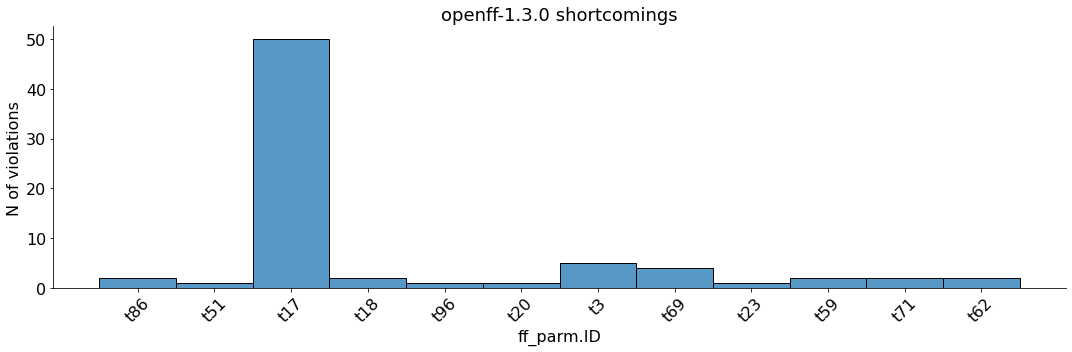

In [23]:
sns.displot(results_df, x = 'parameter', height = 5, aspect = 3)

plt.title('openff-1.3.0 shortcomings', fontsize=18)
plt.xlabel('ff_parm.ID', fontsize=16)
plt.ylabel('N of violations', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

### Wow, `t17` sure looks bad. 

But are we sure it's not just because `t17` is a generic parameter that's just assigned a lot in general? Let's normalize the violation count by the number of times that `t17` is assigned.

In [24]:
# open the coverage report and select torsion parameter exercised in the dataset
with open('data/coverage-report/coverage_report.json', 'r') as f:
    cov = json.load(f)
tor_parms = pd.Series(cov['ProperTorsions'])
tor_parms = tor_parms.reset_index()
tor_parms.columns = ['parameter', 'parm_count']
tor_parms = tor_parms.sort_values(['parm_count', 'parameter'])

# counts number of violations produced by a parameter
counts = results_df['parameter'].value_counts()
counts_df = pd.Series.to_frame(counts)
counts_df.reset_index(level=0, inplace=True)
counts_df = counts_df.rename(columns={'index': 'parameter', 'parameter': 'viol_count'})
counts_df = pd.merge(counts_df, tor_parms, on='parameter', how='inner')
counts_df['rel_viol'] = counts_df['viol_count'] / counts_df['parm_count'] * 100

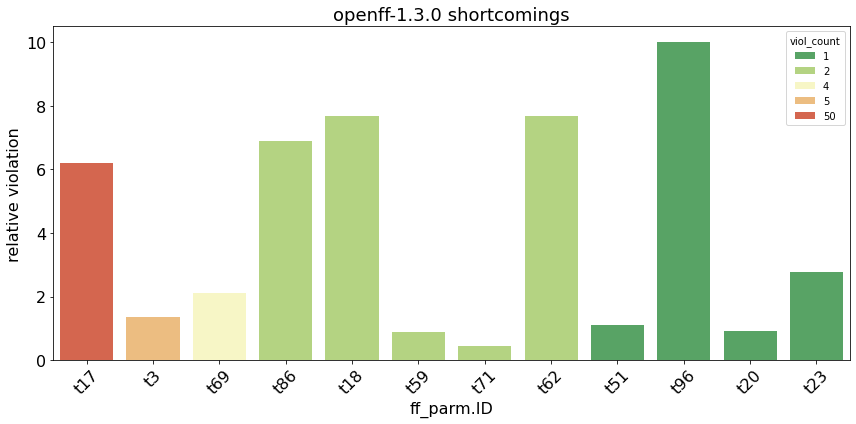

In [25]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='parameter',
            y='rel_viol',
            ax=ax,
            data=counts_df,
            hue='viol_count',
            palette='RdYlGn_r',
            dodge=False)

plt.title('openff-1.3.0 shortcomings', fontsize=18)
plt.xlabel('ff_parm.ID', fontsize=16)
plt.ylabel('relative violation', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()